In [58]:
import LowLevelFEM as FEM
using LowLevelFEM
using SparseArrays
using Plots
using JLD

gmsh.initialize()

In [59]:
gmsh.open("dynamic_energy.geo");

Info    : Reading 'dynamic_energy.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000609745s, CPU 0.000492s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.00201183s, CPU 0.001893s)
Info    : 3321 nodes 3444 elements
Info    : Done reading 'dynamic_energy.geo'


In [60]:
mat = FEM.material("body")
#mat1 = FEM.material("Fe", E=1.96e5, ν=0.25, ρ=7.874e-9)
#mat2 = FEM.material("Al", E=7e4, ν=0.334, ρ=2.7e-9)
#problem = FEM.Problem([mat1, mat2], type="PlaneStress")
problem = FEM.Problem([mat], type="PlaneStress")

Info    : RCMK renumbering...
Info    : Done RCMK renumbering (bandwidth is now 82)


LowLevelFEM.Problem("dynamic_energy", "PlaneStress", 2, [("body", 200000.0, 0.3, 7.85e-9)], 1.0, 3321)

In [61]:
load = FEM.load("right", fx=-1);

In [62]:
K = FEM.stiffnessMatrix(problem);

In [63]:
M = FEM.massMatrix(problem, lumped=true);

In [64]:
f = FEM.loadVector(problem, [load]);

In [65]:
dof = problem.non * problem.dim;

u0 = zeros(dof);
v0 = zeros(dof);


In [66]:
Tₘᵢₙ = FEM.smallestPeriodTime(K, M)

1.4822351095455093e-7

In [67]:
#C = spzeros(dof, dof);
ξₘₐₓ = 1e-3;
β = ξₘₐₓ * Tₘᵢₙ / π;
C = β * K;

In [68]:
E = 7e4;
ρ = 2.7e-9;
c = (E / ρ)^0.5;
time = 15 / c
DT = Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ)
steps = floor(time / DT)

62.0

In [69]:
terhelt = 4;
nagy_blokk_szam = 15; #terhelten kívüli CDM blokkok
blokk_lepes = 40

MERET = terhelt - 1 + (blokk_lepes - 1) * nagy_blokk_szam + 1
display(MERET)

t_full = (0:1:MERET-1) * (Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ));

q_full_in = zeros(1, MERET)
q_full_mid = zeros(1, MERET)
q_full_end = zeros(1, MERET)

u_1, v_1, t_1 = FEM.CDM(K, M, C, f, u0, v0, terhelt * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_1_kezdo = u_1[:, terhelt];
v_1_kezdo = v_1[:, terhelt];
t_1_kezdo = t_1[terhelt];

#display(t_full)

589

1.272613990049149e-7

In [70]:
n2 = blokk_lepes;
f_nul = f * 0;

u_2, v_2, t_2 = FEM.CDM(K, M, C, f_nul, u_1_kezdo, v_1_kezdo, n2 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_2_kezdo = u_2[:, n2];
v_2_kezdo = v_2[:, n2];
t_2_kezdo = t_2[n2];


u_seged = zeros(dof, (terhelt + n2) - 1);
v_seged = zeros(dof, (terhelt + n2) - 1);
t_seged = zeros((terhelt + n2) - 1);

u_seged[:, 1:terhelt] = u_1[:, 1:terhelt];
u_seged[:, terhelt:(terhelt+n2)-1] = u_2[:, 1:n2]; # u_2 itt el tud romolni a kerekítés miatt, ezért át kell vágni

v_seged[:, 1:terhelt] = v_1[:, 1:terhelt];
v_seged[:, terhelt:(terhelt+n2)-1] = v_2[:, 1:n2];

t_eltolas = t_1[terhelt];
t_2 = t_2 .+ t_eltolas;

t_seged[1:terhelt] = t_1[1:terhelt];
t_seged[terhelt:(terhelt+n2)-1] = t_2[1:n2];


################################
S = FEM.solveStress(problem, u_seged);
################################
s = FEM.showStressResults(problem, S, "s", t=t_seged, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_seged, "uvec", t=t_seged, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_seged, "vvec", t=t_seged, name="v", visible=false)
################################

h = 5
np = 10
q_in = 0
X_in = 14.999
#display(t)
q_1 = zeros((terhelt + n2) - 1, 1);
for j ∈ 2:(terhelt+n2-1)
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_seged[j] - t_seged[j-1]
        ss = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        vv = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss * vv * ΔA * Δt
    end
    q_1[j, 1] = q_in
end
#display(q_1)
q_in
##plot(t, q_1)

q_full_in[:, 1:((terhelt+n2)-1)] = q_1';


gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [71]:
display(q_1)

43×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.3494555683463914e-5
 1.3555683514846165e-5
 1.3708956862661737e-5
 1.3755006487245789e-5
 1.3825757894580564e-5
 1.3944861778802747e-5
 1.3982699442784055e-5
 1.4075614452664081e-5
 1.4198296161080317e-5

In [72]:
n3 = blokk_lepes;

u_3, v_3, t_3 = FEM.CDM(K, M, C, f_nul, u_2_kezdo, v_2_kezdo, n3 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_3_kezdo = u_3[:, n3];
v_3_kezdo = v_3[:, n3];
t_3_kezdo = t_3[n3];

################################
S = FEM.solveStress(problem, u_3);
################################
s = FEM.showStressResults(problem, S, "s", t=t_3, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_3, "uvec", t=t_3, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_3, "vvec", t=t_3, name="v", visible=false)
################################


q_mid = 0
q_end = 0
X_mid = 10
X_end = 0.001

q_in_n3 = zeros(n3, 1);
q_mid_n3 = zeros(n3, 1);
q_end_n3 = zeros(n3, 1);

q_in_n3[1] = q_1[n2];

for j ∈ 2:n3
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_3[j] - t_3[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n3[j, 1] = q_in
    q_mid_n3[j, 1] = q_mid
    q_end_n3[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1):1:((terhelt+n2)-1)+n3-1] = q_in_n3';
q_full_mid[:, ((terhelt+n2)-1):1:((terhelt+n2)-1)+n3-1] = q_mid_n3';
q_full_end[:, ((terhelt+n2)-1):1:((terhelt+n2)-1)+n3-1] = q_end_n3';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [73]:
display(q_in_n3)

40×1 Matrix{Float64}:
 1.3944861778802747e-5
 1.42844042268451e-5
 1.4647999081644029e-5
 1.474738816679077e-5
 1.4871204817430223e-5
 1.522101098931133e-5
 1.528822269147525e-5
 1.543704751540517e-5
 1.575652597862013e-5
 1.5761844389332358e-5
 ⋮
 1.687273023307157e-5
 1.6878934486895343e-5
 1.692334903906792e-5
 1.6952667377625886e-5
 1.6951464051619177e-5
 1.6970022899473447e-5
 1.700105817812751e-5
 1.7012688677899737e-5
 1.7023919186773567e-5

In [75]:
n4 = blokk_lepes;

u_4, v_4, t_4 = FEM.CDM(K, M, C, f_nul, u_3_kezdo, v_3_kezdo, n4 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_4_kezdo = u_4[:, n4];
v_4_kezdo = v_4[:, n4];
t_4_kezdo = t_4[n4];

################################
S = FEM.solveStress(problem, u_4);
################################
s = FEM.showStressResults(problem, S, "s", t=t_4, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_4, "uvec", t=t_4, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_4, "vvec", t=t_4, name="v", visible=false)
################################

q_in = q_in_n3[n3];
q_mid = q_mid_n3[n3];
q_end = q_end_n3[n3];

q_in_n4 = zeros(n4, 1);
q_mid_n4 = zeros(n4, 1);
q_end_n4 = zeros(n4, 1);

q_in_n4[1] = q_in_n3[n3];
q_mid_n4[1] = q_mid_n3[n3];
q_end_n4[1] = q_end_n3[n3];

for j ∈ 2:n4
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_4[j] - t_4[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n4[j, 1] = q_in
    q_mid_n4[j, 1] = q_mid
    q_end_n4[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1:1:((terhelt+n2)-1)+n3-1+n4-1] = q_in_n4';
q_full_mid[:, ((terhelt+n2)-1)+n3-1:1:((terhelt+n2)-1)+n3-1+n4-1] = q_mid_n4';
q_full_end[:, ((terhelt+n2)-1)+n3-1:1:((terhelt+n2)-1)+n3-1+n4-1] = q_end_n4';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [76]:
display(q_mid_n4)

40×1 Matrix{Float64}:
 1.4482682364293477e-5
 1.4508750400938335e-5
 1.479994667018968e-5
 1.4877993976425315e-5
 1.492866828028291e-5
 1.5225288302604384e-5
 1.526858285831056e-5
 1.530547440404082e-5
 1.552836925256411e-5
 1.55754636012658e-5
 ⋮
 1.6838740028697962e-5
 1.6749426541021126e-5
 1.6732463679819365e-5
 1.684776765599964e-5
 1.6816779435800505e-5
 1.690118591185835e-5
 1.6938784408956046e-5
 1.6962359805601754e-5
 1.701734012480351e-5

In [78]:
n5 = blokk_lepes;

u_5, v_5, t_5 = FEM.CDM(K, M, C, f_nul, u_4_kezdo, v_4_kezdo, n5 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_5_kezdo = u_5[:, n5];
v_5_kezdo = v_5[:, n5];
t_5_kezdo = t_5[n5];

################################
S = FEM.solveStress(problem, u_5);
################################
s = FEM.showStressResults(problem, S, "s", t=t_5, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_5, "uvec", t=t_5, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_5, "vvec", t=t_5, name="v", visible=false)
################################

q_in = q_in_n4[n4];
q_mid = q_mid_n4[n4];
q_end = q_end_n4[n4];

q_in_n5 = zeros(n5, 1);
q_mid_n5 = zeros(n5, 1);
q_end_n5 = zeros(n5, 1);

q_in_n5[1] = q_in_n4[n4];
q_mid_n5[1] = q_mid_n4[n4];
q_end_n5[1] = q_end_n4[n4];

for j ∈ 2:n5
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_5[j] - t_5[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n5[j, 1] = q_in
    q_mid_n5[j, 1] = q_mid
    q_end_n5[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1] = q_in_n5';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1] = q_mid_n5';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1] = q_end_n5';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [79]:
n6 = blokk_lepes;

u_6, v_6, t_6 = FEM.CDM(K, M, C, f_nul, u_5_kezdo, v_5_kezdo, n6 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_6_kezdo = u_6[:, n6];
v_6_kezdo = v_6[:, n6];
t_6_kezdo = t_6[n6];

################################
S = FEM.solveStress(problem, u_6);
################################
s = FEM.showStressResults(problem, S, "s", t=t_6, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_6, "uvec", t=t_6, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_6, "vvec", t=t_6, name="v", visible=false)
################################

q_in = q_in_n5[n5];
q_mid = q_mid_n5[n5];
q_end = q_end_n5[n5];

q_in_n6 = zeros(n6, 1);
q_mid_n6 = zeros(n6, 1);
q_end_n6 = zeros(n6, 1);

q_in_n6[1] = q_in_n5[n5];
q_mid_n6[1] = q_mid_n5[n5];
q_end_n6[1] = q_end_n5[n5];

for j ∈ 2:n6
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_6[j] - t_6[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n6[j, 1] = q_in
    q_mid_n6[j, 1] = q_mid
    q_end_n6[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1] = q_in_n6';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1] = q_mid_n6';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1] = q_end_n6';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [80]:
n7 = blokk_lepes;

u_7, v_7, t_7 = FEM.CDM(K, M, C, f_nul, u_6_kezdo, v_6_kezdo, n7 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_7_kezdo = u_7[:, n7];
v_7_kezdo = v_7[:, n7];
t_7_kezdo = t_7[n7];

################################
S = FEM.solveStress(problem, u_7);
################################
s = FEM.showStressResults(problem, S, "s", t=t_7, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_7, "uvec", t=t_7, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_7, "vvec", t=t_7, name="v", visible=false)
################################

q_in = q_in_n6[n6];
q_mid = q_mid_n6[n6];
q_end = q_end_n6[n6];

q_in_n7 = zeros(n7, 1);
q_mid_n7 = zeros(n7, 1);
q_end_n7 = zeros(n7, 1);

q_in_n7[1] = q_in_n6[n6];
q_mid_n7[1] = q_mid_n6[n6];
q_end_n7[1] = q_end_n6[n6];

for j ∈ 2:n7
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_7[j] - t_7[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n7[j, 1] = q_in
    q_mid_n7[j, 1] = q_mid
    q_end_n7[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1] = q_in_n7';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1] = q_mid_n7';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1] = q_end_n7';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [81]:
n8 = blokk_lepes;

u_8, v_8, t_8 = FEM.CDM(K, M, C, f_nul, u_7_kezdo, v_7_kezdo, n8 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_8_kezdo = u_8[:, n8];
v_8_kezdo = v_8[:, n8];
t_8_kezdo = t_8[n8];

################################
S = FEM.solveStress(problem, u_8);
################################
s = FEM.showStressResults(problem, S, "s", t=t_8, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_8, "uvec", t=t_8, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_8, "vvec", t=t_8, name="v", visible=false)
################################

q_in = q_in_n7[n7];
q_mid = q_mid_n7[n7];
q_end = q_end_n7[n7];

#display(t)
q_in_n8 = zeros(n8, 1);
q_mid_n8 = zeros(n8, 1);
q_end_n8 = zeros(n8, 1);

q_in_n8[1] = q_in_n7[n7];
q_mid_n8[1] = q_mid_n7[n7];
q_end_n8[1] = q_end_n7[n7];

for j ∈ 2:n8
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_8[j] - t_8[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n8[j, 1] = q_in
    q_mid_n8[j, 1] = q_mid
    q_end_n8[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1] = q_in_n8';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1] = q_mid_n8';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1] = q_end_n8';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [82]:
n9 = blokk_lepes;

u_9, v_9, t_9 = FEM.CDM(K, M, C, f_nul, u_8_kezdo, v_8_kezdo, n9 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_9_kezdo = u_9[:, n9];
v_9_kezdo = v_9[:, n9];
t_9_kezdo = t_9[n9];

################################
S = FEM.solveStress(problem, u_9);
################################
s = FEM.showStressResults(problem, S, "s", t=t_9, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_9, "uvec", t=t_9, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_9, "vvec", t=t_9, name="v", visible=false)
################################

q_in = q_in_n8[n8];
q_mid = q_mid_n8[n8];
q_end = q_end_n8[n8];

#display(t)
q_in_n9 = zeros(n9, 1);
q_mid_n9 = zeros(n9, 1);
q_end_n9 = zeros(n9, 1);

q_in_n9[1] = q_in_n8[n8];
q_mid_n9[1] = q_mid_n8[n8];
q_end_n9[1] = q_end_n8[n8];

for j ∈ 2:n9
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_9[j] - t_9[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n9[j, 1] = q_in
    q_mid_n9[j, 1] = q_mid
    q_end_n9[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1] = q_in_n9';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1] = q_mid_n9';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1] = q_end_n9';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [83]:
n10 = blokk_lepes;

u_10, v_10, t_10 = FEM.CDM(K, M, C, f_nul, u_9_kezdo, v_9_kezdo, n10 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_10_kezdo = u_10[:, n10];
v_10_kezdo = v_10[:, n10];
t_10_kezdo = t_10[n10];

################################
S = FEM.solveStress(problem, u_10);
################################
s = FEM.showStressResults(problem, S, "s", t=t_10, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_10, "uvec", t=t_10, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_10, "vvec", t=t_10, name="v", visible=false)
################################

q_in = q_in_n9[n9];
q_mid = q_mid_n9[n9];
q_end = q_end_n9[n9];

#display(t)
q_in_n10 = zeros(n10, 1);
q_mid_n10 = zeros(n10, 1);
q_end_n10 = zeros(n10, 1);

q_in_n10[1] = q_in_n9[n9];
q_mid_n10[1] = q_mid_n9[n9];
q_end_n10[1] = q_end_n9[n9];

for j ∈ 2:n10
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_10[j] - t_10[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n10[j, 1] = q_in
    q_mid_n10[j, 1] = q_mid
    q_end_n10[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1] = q_in_n10';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1] = q_mid_n10';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1] = q_end_n10';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [85]:
n11 = blokk_lepes;

u_11, v_11, t_11 = FEM.CDM(K, M, C, f_nul, u_10_kezdo, v_10_kezdo, n11 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_11_kezdo = u_11[:, n11];
v_11_kezdo = v_11[:, n11];
t_11_kezdo = t_11[n11];

################################
S = FEM.solveStress(problem, u_11);
################################
s = FEM.showStressResults(problem, S, "s", t=t_11, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_11, "uvec", t=t_11, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_11, "vvec", t=t_11, name="v", visible=false)
################################

q_in = q_in_n10[n10];
q_mid = q_mid_n10[n10];
q_end = q_end_n10[n10];

q_in_n11 = zeros(n11, 1);
q_mid_n11 = zeros(n11, 1);
q_end_n11 = zeros(n11, 1);

q_in_n11[1] = q_in_n10[n10];
q_mid_n11[1] = q_mid_n10[n10];
q_end_n11[1] = q_end_n10[n10];

for j ∈ 2:n11
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_11[j] - t_11[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n11[j, 1] = q_in
    q_mid_n11[j, 1] = q_mid
    q_end_n11[j, 1] = q_end
end




q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1] = q_in_n11';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1] = q_mid_n11';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1] = q_end_n11';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [87]:
n12 = blokk_lepes;

u_12, v_12, t_12 = FEM.CDM(K, M, C, f_nul, u_11_kezdo, v_11_kezdo, n12 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_12_kezdo = u_12[:, n12];
v_12_kezdo = v_12[:, n12];
t_12_kezdo = t_12[n12];

################################
S = FEM.solveStress(problem, u_12);
################################
s = FEM.showStressResults(problem, S, "s", t=t_12, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_12, "uvec", t=t_12, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_12, "vvec", t=t_12, name="v", visible=false)
################################

q_in = q_in_n11[n11];
q_mid = q_mid_n11[n11];
q_end = q_end_n11[n11];

q_in_n12 = zeros(n12, 1);
q_mid_n12 = zeros(n12, 1);
q_end_n12 = zeros(n12, 1);

q_in_n12[1] = q_in_n11[n11];
q_mid_n12[1] = q_mid_n11[n11];
q_end_n12[1] = q_end_n11[n11];

for j ∈ 2:n12
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_12[j] - t_12[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n12[j, 1] = q_in
    q_mid_n12[j, 1] = q_mid
    q_end_n12[j, 1] = q_end
end
q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1] = q_in_n12';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1] = q_mid_n12';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1] = q_end_n12';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)



In [88]:
n13 = blokk_lepes;

u_13, v_13, t_13 = FEM.CDM(K, M, C, f_nul, u_12_kezdo, v_12_kezdo, n13 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_13_kezdo = u_13[:, n13];
v_13_kezdo = v_13[:, n13];
t_13_kezdo = t_13[n13];

################################
S = FEM.solveStress(problem, u_13);
################################
s = FEM.showStressResults(problem, S, "s", t=t_13, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_13, "uvec", t=t_13, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_13, "vvec", t=t_13, name="v", visible=false)
################################

q_in = q_in_n12[n12];
q_mid = q_mid_n12[n12];
q_end = q_end_n12[n12];

q_in_n13 = zeros(n13, 1);
q_mid_n13 = zeros(n13, 1);
q_end_n13 = zeros(n13, 1);

q_in_n13[1] = q_in_n12[n12];
q_mid_n13[1] = q_mid_n12[n12];
q_end_n13[1] = q_end_n12[n12];

for j ∈ 2:n13
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_13[j] - t_13[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n13[j, 1] = q_in
    q_mid_n13[j, 1] = q_mid
    q_end_n13[j, 1] = q_end
end
q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1] = q_in_n13';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1] = q_mid_n13';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1] = q_end_n13';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [89]:
n14 = blokk_lepes;

u_14, v_14, t_14 = FEM.CDM(K, M, C, f_nul, u_13_kezdo, v_13_kezdo, n14 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_14_kezdo = u_14[:, n14];
v_14_kezdo = v_14[:, n14];
t_14_kezdo = t_14[n14];

################################
S = FEM.solveStress(problem, u_14);
################################
s = FEM.showStressResults(problem, S, "s", t=t_14, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_14, "uvec", t=t_14, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_14, "vvec", t=t_14, name="v", visible=false)
################################

q_in = q_in_n13[n13];
q_mid = q_mid_n13[n13];
q_end = q_end_n13[n13];

q_in_n14 = zeros(n14, 1);
q_mid_n14 = zeros(n14, 1);
q_end_n14 = zeros(n14, 1);

q_in_n14[1] = q_in_n13[n13];
q_mid_n14[1] = q_mid_n13[n13];
q_end_n14[1] = q_end_n13[n13];

for j ∈ 2:n14
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_14[j] - t_14[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n14[j, 1] = q_in
    q_mid_n14[j, 1] = q_mid
    q_end_n14[j, 1] = q_end
end

q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1] = q_in_n14';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1] = q_mid_n14';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1] = q_end_n14';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [90]:
n15 = blokk_lepes;

u_15, v_15, t_15 = FEM.CDM(K, M, C, f_nul, u_14_kezdo, v_14_kezdo, n15 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_15_kezdo = u_15[:, n15];
v_15_kezdo = v_15[:, n15];
t_15_kezdo = t_15[n15];

################################
S = FEM.solveStress(problem, u_15);
################################
s = FEM.showStressResults(problem, S, "s", t=t_15, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_15, "uvec", t=t_15, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_15, "vvec", t=t_15, name="v", visible=false)
################################

q_in = q_in_n14[n14];
q_mid = q_mid_n14[n14];
q_end = q_end_n14[n14];

q_in_n15 = zeros(n15, 1);
q_mid_n15 = zeros(n15, 1);
q_end_n15 = zeros(n15, 1);

q_in_n15[1] = q_in_n14[n14];
q_mid_n15[1] = q_mid_n14[n14];
q_end_n15[1] = q_end_n14[n14];

for j ∈ 2:n15
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_15[j] - t_15[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n15[j, 1] = q_in
    q_mid_n15[j, 1] = q_mid
    q_end_n15[j, 1] = q_end
end
q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1] = q_in_n15';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1] = q_mid_n15';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1] = q_end_n15';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

In [91]:
n16 = blokk_lepes;

u_16, v_16, t_16 = FEM.CDM(K, M, C, f_nul, u_15_kezdo, v_15_kezdo, n16 * Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ), Tₘᵢₙ / π * (√(1 + ξₘₐₓ^2) - ξₘₐₓ) * 0.9);

u_16_kezdo = u_16[:, n16];
v_16_kezdo = v_16[:, n16];
t_16_kezdo = t_16[n16];

################################
S = FEM.solveStress(problem, u_16);
################################
s = FEM.showStressResults(problem, S, "s", t=t_16, name="σred", visible=true, smooth=false)
################################
uvec = FEM.showDoFResults(problem, u_16, "uvec", t=t_16, name="u", visible=false)
################################
vvec = FEM.showDoFResults(problem, v_16, "vvec", t=t_16, name="v", visible=false)
################################

q_in = q_in_n15[n15];
q_mid = q_mid_n15[n15];
q_end = q_end_n15[n15];

q_in_n16 = zeros(n16, 1);
q_mid_n16 = zeros(n16, 1);
q_end_n16 = zeros(n16, 1);

q_in_n16[1] = q_in_n15[n15];
q_mid_n16[1] = q_mid_n15[n15];
q_end_n16[1] = q_end_n15[n15];

for j ∈ 2:n16
    for i ∈ 1:np
        ΔA = h / np
        y = (h / np) * (i - 1) + (h / np / 2)
        Δt = t_16[j] - t_16[j-1]
        ss_in = reshape(gmsh.view.probe(s, X_in, y, 0, j - 1)[1], 3, 3)
        ss_mid = reshape(gmsh.view.probe(s, X_mid, y, 0, j - 1)[1], 3, 3)
        ss_end = reshape(gmsh.view.probe(s, X_end, y, 0, j - 1)[1], 3, 3)
        vv_in = gmsh.view.probe(vvec, X_in, y, 0, j - 1)[1]
        vv_mid = gmsh.view.probe(vvec, X_mid, y, 0, j - 1)[1]
        vv_end = gmsh.view.probe(vvec, X_end, y, 0, j - 1)[1]
        q_in += [1, 0, 0]' * ss_in * vv_in * ΔA * Δt
        q_mid += [1, 0, 0]' * ss_mid * vv_mid * ΔA * Δt
        q_end += [1, 0, 0]' * ss_end * vv_end * ΔA * Δt
    end
    q_in_n16[j, 1] = q_in
    q_mid_n16[j, 1] = q_mid
    q_end_n16[j, 1] = q_end
end
q_full_in[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1+n16-1] = q_in_n16';
q_full_mid[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1+n16-1] = q_mid_n16';
q_full_end[:, ((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1:1:((terhelt+n2)-1)+n3-1+n4-1+n5-1+n6-1+n7-1+n8-1+n9-1+n10-1+n11-1+n12-1+n13-1+n14-1+n15-1+n16-1] = q_end_n16';

gmsh.view.remove(s)
gmsh.view.remove(uvec)
gmsh.view.remove(vvec)

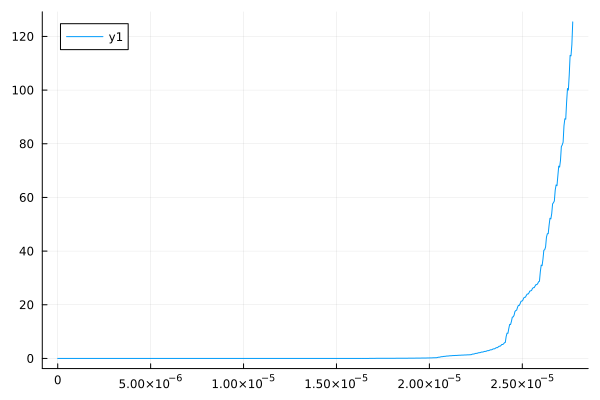

In [92]:
plot(t_full, q_full_in')

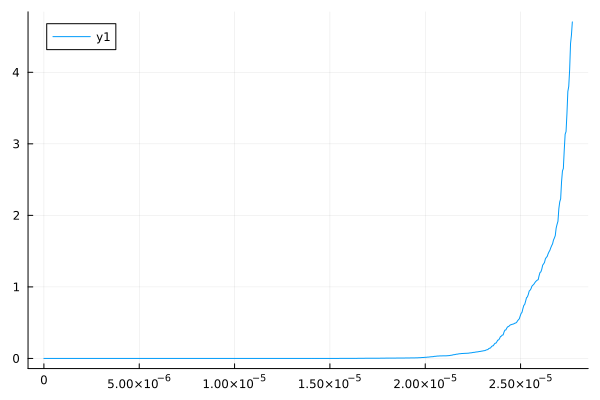

In [93]:
plot(t_full, q_full_mid')

In [94]:
display(t_full)

0.0:4.713385148330181e-8:2.7714704672181466e-5

In [95]:
display(q_full_mid)

1×589 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  4.03545  4.40181  4.52  4.70428

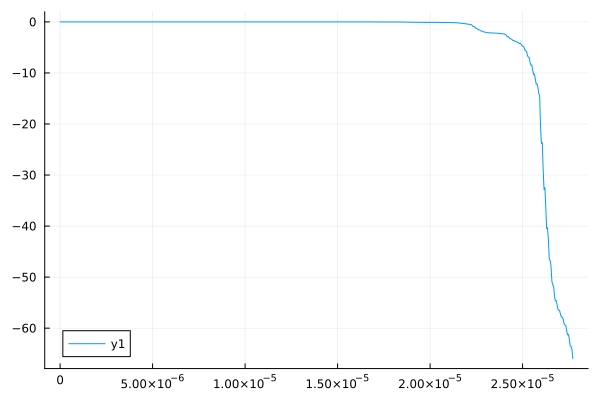

In [96]:
plot(t_full, q_full_end')

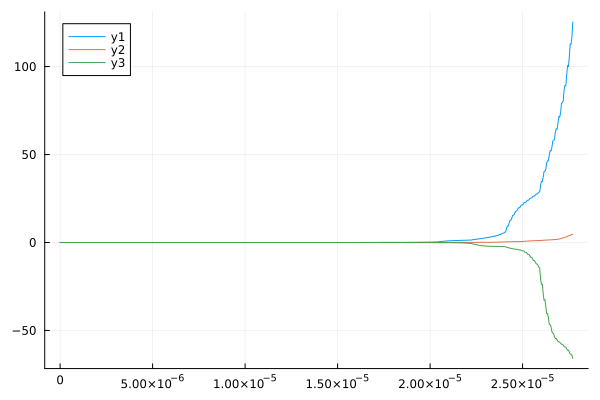

In [97]:
plot(t_full, q_full_in')
plot!(t_full, q_full_mid')
plot!(t_full, q_full_end')


#save("t_full.jld", "t_full",t_full)
#save("q_full_in.jld", "q_full_in",q_full_in)
#save("q_full_mid.jld", "q_full_mid",q_full_mid)
#save("q_full_end.jld", "q_full_end",q_full_end)

#b = load("q_full_in.jld","t_full")
#c = load("q_full_mid.jld")
#d = load("q_full_end.jld")

In [98]:
################################
# Kompenzálás csillapításból
Δt = t_16[2] - t_16[1]
C_E = 0;
for i ∈ 1:terhelt
     C_E += v_seged[:, i]' * C * v_seged[:, i] * Δt
end
################################
display(C_E)

2.7589697636365285e-8

In [99]:
#Wi = [(u[:, i] - u[:, i-1])' * (i > 5 ? f * 0 : f) for i in 2:n-1]
Wi = [(u_seged[:, i] - u_seged[:, i-1])' * f for i in 2:4]
W = sum(Wi)
################################

2.9652012823884942e-5

In [100]:
#U = u[:, n-1]' * K * u[:, n-1] / 2 + v[:, n-1]' * M * v[:, n-1] / 2
nn = 4    # vagy 5
U = u_seged[:, nn]' * K * u_seged[:, nn] / 2 + v_seged[:, nn]' * M * v_seged[:, nn] / 2
################################

2.7424419451608226e-5

In [101]:
################################

In [102]:
#display(U)
#display(W)
#display(q)
(U - W) / U * 100

-8.122663731159076

In [103]:
(U - q_in) / U * 100

-4.572877325917133e8

In [104]:
(W - q_in) / W * 100

-4.2293420147885907e8

In [105]:
((U + C_E) - W) / U * 100

-8.022061063215462

In [106]:
(U + C_E - q_in) / U * 100

-4.572877324911106e8

In [107]:
#gmsh.fltk.run()

In [108]:
#gmsh.finalize()